In [ ]:
import pandas as pd                                     
import numpy as np                                   
import os                                               
import matplotlib.pyplot as plt                         
import scipy.stats.mstats as ssm                        
from scipy.stats import gaussian_kde as kde
import random

%matplotlib inline

Our first task is to transform the dataset into something meaningfully that we can use in our classifier. To do that we are going to aggregate the data based on the player and we are going to do that in the following way:
    1. Columns: playerShort, club, leagueCountry, birthday, height, weight and, position just get copied
    2. We drop column: player since the playerShort column is unique
    3. Columns: games, victories, ties, defeats, goals, yellowCards, yellowReds and, redCards get summed up
    4. We drop the photoID column
    5. Then we average the rating of the skin colour
    6. We then drop columns: refNum, refCountry and, Alpha_3
    7. We also drop nIAT, nExp, then average meanIAT, meanExp and calculate new seIAT, seExp based on the variance of the values we used in the averaging of meanIAT and meanExp.




In [ ]:
df = pd.read_csv('CrowdstormingDataJuly1st.csv')

Let's check that the data was loaded 

In [ ]:
df.head(5)

Ok now, let's make the playerShort the index, also let's average the skintone and drop all players that have the skintone as NaN. Plus, we average the player skintone.

In [ ]:
#df.set_index(df.columns[0], inplace=True)
df.dropna(subset=['rater1', 'rater2'], inplace=True)
df['skintone']=df[['rater1', 'rater2']].mean(axis=1)
df.head(10)

The next step is to change the format of the data and keep only relevant fields.

In [ ]:
df.drop(['player', 'rater1', 'rater2', 'photoID', 'birthday'], inplace=True, axis=1)
df.head()

Now we will collapse these entries so that we have one row per player. We aggregate numerical values either by summing or averaging, and most frequent strings are selected (unless for 

In [ ]:
players_grouped = df.groupby(by=['playerShort'])

fdict = dict.fromkeys(['club', 'leagueCountry'], lambda x: x.value_counts().index[0])
fdict.update({'position': lambda x: x.index[0]})
fdict.update(dict.fromkeys(['meanIAT', 'meanExp', 'seIAT', 'seExp', 'height', 'weight', 'skintone'], lambda x: np.mean(x)))
fdict.update(dict.fromkeys(['games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards'], np.sum))

data = players_grouped.agg(fdict)
data.reset_index(inplace=True, drop=True)
labels = data[['skintone']]
data.drop('skintone', inplace=True, axis=1)
data.head()

Now we need to deal with the text features. Our model does not like text features so we have to encode them as numbers. There are two ways of doing this.
1. We relate each text value to a number
2. For each text value we add a new column and set it to 0 where that text value does not appear and 1 where it appers

In general it it suggested to use the second aproach, but in our case I will use the first aproach for 2 reasons: 
-There are a lot of clubs and that will add a lot of columns
-It will make it very dificult to inspect the feature_importances_

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le1 = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
le.fit(data['leagueCountry'])
le1.fit(data['club'])
le2.fit(data['position'].dropna())

In [ ]:
data['leagueCountry'] = le.transform(data['leagueCountry'])
data['club'] = le1.transform(data['club'])
data['position'] = data['position'].fillna(le2.inverse_transform(np.median(le2.transform(data['position'].dropna())).astype(int)))
data['position'] = le2.transform(data['position'])
data.head()

Our model also does not like NaN values so we will fill them with the median of the respetive column

In [ ]:
data['height'] = data['height'].fillna(np.median(data['height'].dropna()))
data['weight'] = data['weight'].fillna(np.median(data['weight'].dropna()))

In [ ]:
#data.set_index(data.columns[0], inplace=True)

In [ ]:
labels = labels.apply(lambda x: np.round(x))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn import metrics
def checkCrossValidationAccuracy (data, labels):
    scores = []
    kf = KFold(len(labels), n_folds=20, shuffle=True, random_state=123)
    for train_index, test_index in kf:
        clf = RandomForestClassifier(n_estimators=15)
        X_train, X_test = data.loc[train_index], data.loc[test_index]
        y_train, y_test = labels.loc[train_index], labels.loc[test_index]
        clf.fit(X_train, y_train['skintone'])
        scores.append(metrics.accuracy_score(y_test['skintone'], clf.predict(X_test)))
        #print(metrics.accuracy_score(y_test['skintone'], clf.predict(X_test)))
        #print(metrics.accuracy_score(y_train['skintone'], clf.predict(X_train)))
    return np.average(scores) 
checkCrossValidationAccuracy(data,labels)

Okay now let's try dropping some cols. Let's drop the club and the leagueCountry as those atributs should not affect the player

In [ ]:
data1 = data.drop("leagueCountry", 1)
data1 = data1.drop("club", 1)

In [ ]:
checkCrossValidationAccuracy(data1,labels)

It looks like droping thoose features did not increase the accuracy but at the same time it simplified the model

In [ ]:
data2 = data1.drop("games", 1)
data2 = data2.drop("victories", 1)
data2 = data2.drop("ties", 1)
data2 = data2.drop("defeats", 1)

In [ ]:
data2.head()

In [ ]:
checkCrossValidationAccuracy(data2,labels)

In [ ]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(data2, labels['skintone'])
clf.feature_importances_

Let's try to join the yellowReds and redCards columns

In [ ]:
data3 = data2
data3['redCards'] = data3['redCards'] + data3['yellowReds']
data3 = data3.drop("yellowReds", 1)

In [ ]:
checkCrossValidationAccuracy(data3,labels)

In [ ]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(data3, labels['skintone'])
clf.feature_importances_

Let's also try to remove the position 

In [ ]:
data4 = data3.drop("position", 1)

In [ ]:
checkCrossValidationAccuracy(data4,labels)

We can also try to join the yellow cards and red cards in one column named cards

In [ ]:
data5 = data4
data5['cards'] = data5['redCards'] + data5['yellowCards']
data5 = data5.drop('redCards', 1)
data5 = data5.drop('yellowCards', 1)
data5.head()

In [ ]:
checkCrossValidationAccuracy(data5,labels)

In [ ]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(data5, labels['skintone'])
clf.feature_importances_

The final simplification that we can try is to eleminate all data that is not connected to the cards

In [ ]:
data6 = data5.drop('height', 1)
data6 = data6.drop("weight", 1)

In [ ]:
checkCrossValidationAccuracy(data6,labels) 

In [ ]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(data6, labels['skintone'])
clf.feature_importances_

## PART 2

In [ ]:
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

We recuperate the aggregated dataframe we computed earlier

In [ ]:
part2df = players_grouped.agg(fdict)
part2df.reset_index(inplace=True, drop=True)
part2df.head()

We only want the numeric data

In [ ]:
part2df = part2df._get_numeric_data()

In [ ]:
part2df.head()

We transform skintone into discrete values 0 and 1

In [ ]:
part2df['skintone'] = part2df['skintone'].apply(lambda x: 1 if x>=0.5 else 0)
part2df.head()

We then drop rows that contain at least one NaN, because KMeans can't work with that

In [ ]:
part2df.dropna(inplace=True)

In [ ]:
#df_train, df_test = sklearn.cross_validation.train_test_split(part2df, train_size=0.6)

kmean = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)
kmean.fit(part2df)
labels = kmean.labels_
kmean.cluster_centers_.shape

We'll now use "principal component analysis" to plot the output, PCA tries to merge the columns to be able to print them in 2D while keeping the structure of the multidimensional clusters

In [ ]:
from sklearn.decomposition import PCA

# Create a PCA model.
pca_2 = PCA(2)
# Fit the PCA model on the numeric columns from earlier.
plot_columns = pca_2.fit_transform(part2df)
# Make a scatter plot of each game, shaded according to cluster assignment.
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)
# Show the plot.
plt.show()

In [ ]:
sklearn.metrics.silhouette_score(part2df, labels, metric='euclidean')

In [ ]:
part2df.corr()['skintone']

In [ ]:
avgSkintone = part2df.groupby(labels).mean()['skintone'].values
avgSkintone

We will now remove one column at a time and print the result.
First we will put skintone in first position since we don't want to drop it

In [94]:
cols = part2df.columns.tolist()
cols[0], cols[2] = cols[2], cols[0]
shortenedDF = part2df[cols]
shortenedDF.head()
#shortenedDF = shortenedDF.drop('position', axis=1) #this column pretty much ruins everything so maybe we should remove it

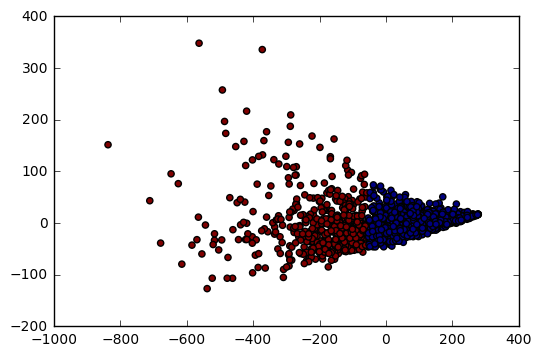

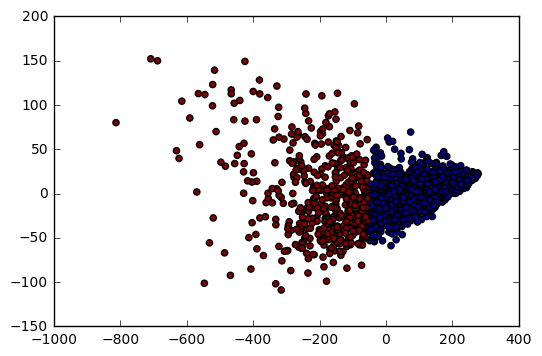

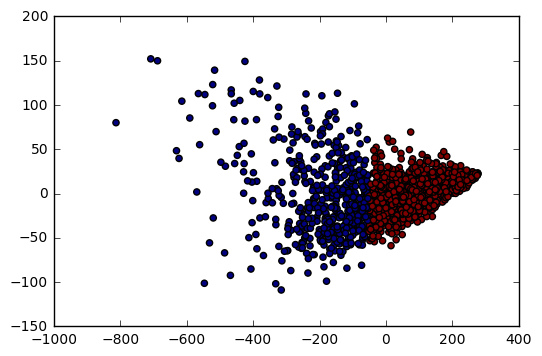

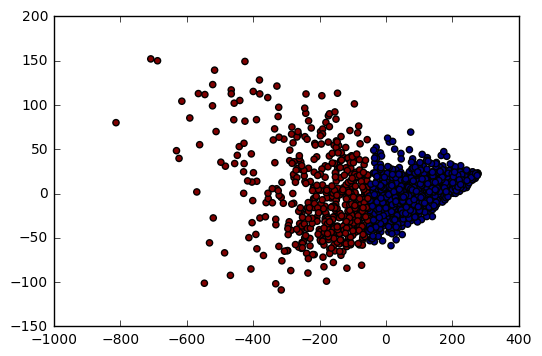

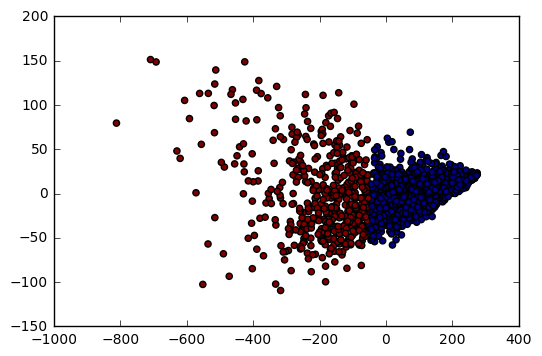

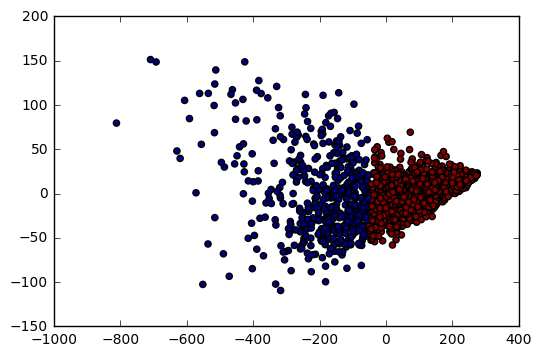

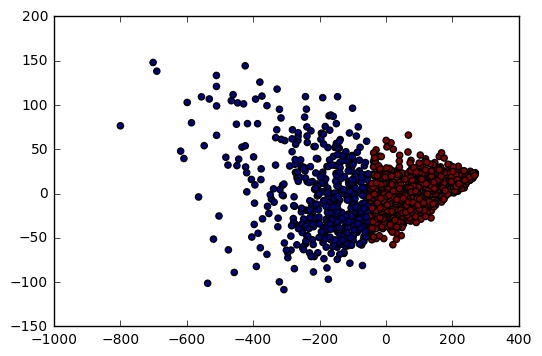

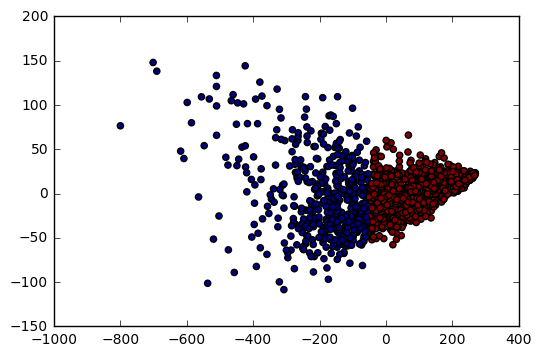

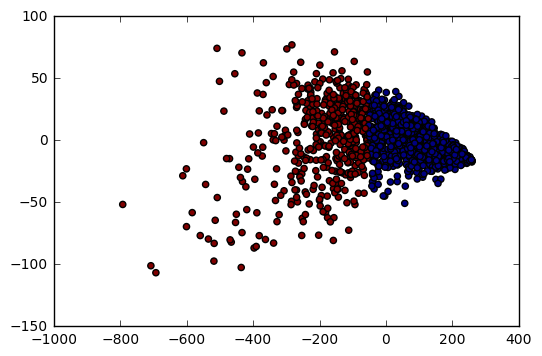

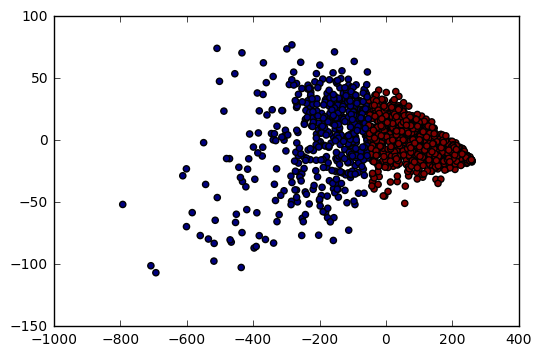

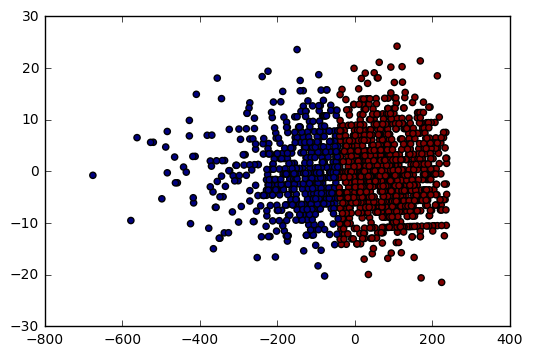

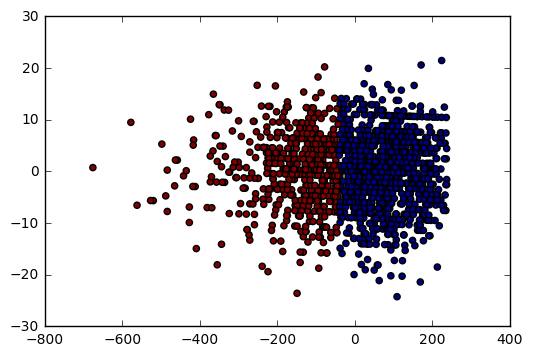

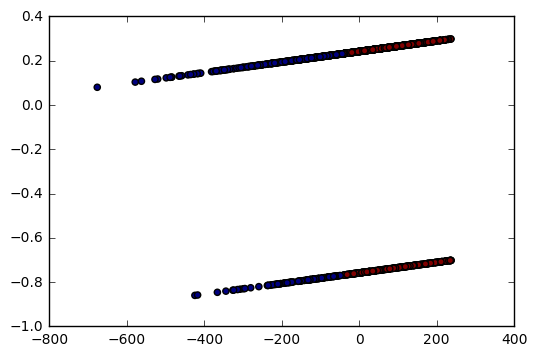

ValueError: n_components=2 invalid for n_features=1

In [95]:
silhouette_scores = []
avg_skintones = []
#the code down below is just reused code already explained earlier. The only difference is that we store the outputs in tables to compare them later
for i in range (shortenedDF.shape[1]-1,  0, -1):
    shortenedDF = shortenedDF.drop(shortenedDF.columns[i], axis=1)
    kmean.fit(shortenedDF)
    labels = kmean.labels_
    silhouette_scores.append(sklearn.metrics.silhouette_score(shortenedDF, labels, metric='euclidean'))
    avg_skintones.append(shortenedDF.groupby(labels).mean()['skintone'].values)
    plot_columns = pca_2.fit_transform(shortenedDF)
    plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)
    plt.show()

In [97]:
silhouette_scores

[0.54549628349920909,
 0.56176294943181404,
 0.56180898680585978,
 0.56346392025630365,
 0.57313104470419685,
 0.57320136943869093,
 0.57614801327085119,
 0.57614848216119618,
 0.58861361658483902,
 0.5886136166370306,
 0.59750612660904612,
 0.59750612955040394,
 0.60238268799515637,
 1.0]

In [96]:
avg_skintones

[array([ 0.25210084,  0.21906694]),
 array([ 0.2518797,  0.22     ]),
 array([ 0.22     ,  0.2518797]),
 array([ 0.2518797,  0.22     ]),
 array([ 0.25234522,  0.2188755 ]),
 array([ 0.2188755 ,  0.25234522]),
 array([ 0.2188755 ,  0.25234522]),
 array([ 0.2188755 ,  0.25234522]),
 array([ 0.25163094,  0.21995927]),
 array([ 0.21995927,  0.25163094]),
 array([ 0.21289062,  0.25570342]),
 array([ 0.25570342,  0.21289062]),
 array([ 0.21289062,  0.25570342]),
 array([0, 1], dtype=int64)]